In [1]:
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy import optimize


# Combining Kis
It's known that the ligand species arising from multiple protonation or tautomer states of a ligand will often bind with different Ki's (inhibition constant) to a target of interest. How does this affect your observed Ki in experiment? If predict the individual Ki's, and we estimate the populations of the tautomeric or protonation states, can we then combine them into a predicted Ki for the mixture of species?

There are (at least) three papers that suggest how to do this:
- Combining protomer energies seems to have been addressed for FEP+ simulations in [this Schrodinger paper](https://doi.org/10.1021/acs.jctc.8b00826), equation 4. That may well be correct, but the math is missing a step for me.
- [This paper](https://doi.org/10.1021/ct1002913), equation 22, deals with combining Ki's from multiple conformations on the _protein_ side (for a single ligand species), by summing the equilibrium binding constants for each conformation, each being weighted by the population of that conformation.
- Finally, [this article](https://pubmed.ncbi.nlm.nih.gov/23170882/) presents a "master equation" that governs the contributions of all ligand _and_ protein species (protomers, tautomers, and conformations), along with their binding modes. The derivation seems clearer to me - it's a big, messy equation but made of little, easier pieces. And it seems to match the previous derivations to my eye. So let's start with this one.

The 'master equation' looks like this:

![img](https://raw.githubusercontent.com/data2code/afpdb/refs/heads/main/tutorial/img/afpdb.png)



# Validation by simulation
We can't validate the 'master equation' theory by experiment, because we can't isolate a ligand species, measure its Ki separately, and then compare the combined Ki to the experimental mixture. Although, more than 50 years ago [Martin and Hansch](https://pubmed.ncbi.nlm.nih.gov/5140003/) were seeing implicit experimental support for this by incorporating the fraction of charged ligand species into their QSAR models.

Instead we can use simulation, where we _can_ control and measure sub-species concentrations. This notebook is a simulation of a ligand with two tautomer species binding to a protein with one conformation to see how closely the 'combined Ki' master equation matches observations from the mixture. It works like this:
- Using an ODE, we can simulate the % of free ligand, free protein, and bound complex that is implied by a reversible reaction `P+L<->PL`
- Likewise, we can simulate the % of tautomer species in the same way, where the reversible reaction is `L1<->L2`
- Likewise, we can simulate the % of each unbound and bound tautomer species to a protein, `P+L1+L2<->PL1+L2<->PL1+PL2<->PL2+L1`. In practice we only care about `PL1+PL2`, because that's what is measurable in a real experiment, i.e. it represents the combined Ki
- To set up these simulations, we would input the on-rate and off-rate for each process. Since the equilibrium binding constant is just on-rate/off-rate, we know the individual Ki's of each ligand species in this simulation, so we know exactly how to generate a combined Ki using the master equation.
- After the simulation of the protein and the ligand species mixture, we can then fit a kinetic model to the signal from the combined `PL1+PL2`, as you would have to do in an experiment, to generate the "experimental" apparent Ki.
- Finally, we can compare the apparent Ki (from our simulated 'experimental' data) to the predicted combined Ki (from the master equation) and see if the two match up. 

# Start with the tautomers
To make the master equation work, we'd need the tautomer transition reaction to happen much faster than the protein complexation process. For many tautomers of interest, this is a plausible assumption (see the paper). In this case, I set the on- and off-rates of the tautomer transition to lead to ~95% tautomer 1, and 5% tautomer 2, with pretty fast off-rate compared to what you might see in a protein-ligand system. The cell below generates an equilibrated solution of the tautomers, beginning from an out-of-equilibrium equal mixture (impossible to realise in practice) and then equilibrating. The equilibration happens in 2 seconds because the rates are fast. 

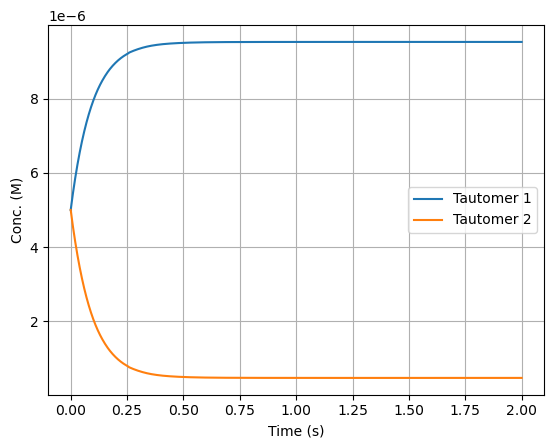

In [2]:
def rate_equations(y, t, k_tau1, k_tau2):
    L1, L2 = y  # Unpack the concentrations
    # Rate equations
    dL1dt = k_tau2 * L2 - k_tau1 * L1
    dL2dt = k_tau1 * L1 - k_tau2 * L2 
    return [dL1dt, dL2dt]

#initialise concentrations to the starting state:
L1_0 = 5e-6  # 5 μM
L2_0 = 5e-6  # 5 μM
k_tau1 = 0.5   # in M^-1 s^-1 #this could be considered the off-rate
k_tau2 = 10  # in s^-1 #which makes this the on-rate. Remember the reaction is reversible
             # so on- and off-rates both happen at same time. Molar Units in the 'on' rate are a convention.
# Initial conditions
y0 = [L1_0, L2_0]

# Time points for the simulation
t = np.linspace(0, 2, 1000)  # 2 second simulation. It's fast, so 2s is all we need!

# Integrate the rate equations
y = odeint(rate_equations, y0, t, args=(k_tau1, k_tau2))

# Extract the concentrations
L1 = y[:, 0]
L2 = y[:, 1]
plt.plot(t, L1, label='Tautomer 1')
plt.plot(t, L2, label='Tautomer 2')
plt.legend()
plt.ylabel('Conc. (M)')
plt.xlabel('Time (s)')
plt.grid()

so our system equilibrates nice and quickly. Let's plot it as % populations instead:


(0.0, 100.0)

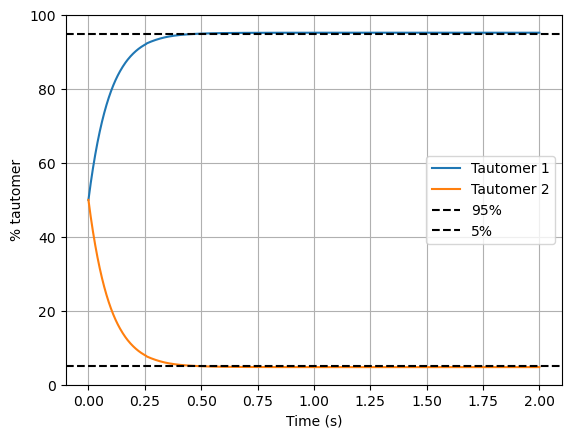

In [3]:
plt.plot(t, L1/(L1+L2)*100, label='Tautomer 1')
plt.plot(t, L2/(L1+L2)*100, label='Tautomer 2')
plt.axhline(95, c='k', linestyle='--', label='95%')
plt.axhline(5, c='k', linestyle='--', label='5%')

plt.legend()
plt.ylabel('% tautomer')
plt.xlabel('Time (s)')

plt.grid()
plt.ylim(0, 100)

In [4]:
#calculate the fraction of each tautomer in the equilibrated state.
#f1 = fraction of tautomer 1. 
f1 = L1[-1]/(L1[-1]+L2[-1])
f2 = L2[-1]/(L1[-1]+L2[-1])
print('Equilibrium fraction of tautomer 1:', f1)
print('Equilibrium fraction of tautomer 2:', f2)

Equilibrium fraction of tautomer 1: 0.952386929349295
Equilibrium fraction of tautomer 2: 0.04761307065070506


# Now move to a tautomer + protein simulation. 
To make the protein-binding simulation work, we'll first need to think up some on-rates and off-rates for the complexation of tautomer 1 with protein, and the complexation of tautomer 2 with protein. 

I purposely set these so that tautomer 2, which is the minor tautomer, is much more potent. The point of this is to see how our measured Ki looks like when the minor tautomer is more potent. Looking at [the affinity plot on SPRPages](https://www.sprpages.nl/troubleshooting/high-affinity), these values are somewhat realistic for real ligands of interest. 

Note the printed Ki's after the cell. In µM, these are:
- 1 µMolar
- 5 nanoMolar

In [5]:
# set some protein equilibrium binding constants using on and off rates:
# Rate constants
k_on1 = 1e3    #  M^-1 s^-1
k_off1 = 1e-3     # s^-1
k_on2 = 2e5    # M^-1 s^-1
k_off2 = 1e-3  # s^-1

#these are the true equilibrium binding constants
true_taut1_k_eq = (k_on1/k_off1)
true_taut2_k_eq = (k_on2/k_off2)

#and these are the true Ki's
true_taut1_ki = 1/true_taut1_k_eq
true_taut2_ki = 1/true_taut2_k_eq
print('K_i for tautomer 1 (in Molar):', true_taut1_ki)
print('K_i for tautomer 2 (in Molar):', true_taut2_ki)


K_i for tautomer 1 (in Molar): 1e-06
K_i for tautomer 2 (in Molar): 5e-09


# Run the protein-binding simulation using the pre-equilibrated tautomer mixture. 
This is pretty much the same as the tautomer situation, however the ODE equation is a little bit more involved in order to handle ligand-protein binding at the same time as regeneration of the tautomer populations amongst the unbound fraction!

In [6]:
# Define the rate equations
def rate_equations(y, t, k_on1, k_off1, k_on2, k_off2, k_tau1, k_tau2):
    P, L1, L2, PL1, PL2 = y  # Unpack the concentrations
    # Rate equations
    dPdt = -k_on1 * P * L1 + k_off1 * PL1 - k_on2 * P * L2 + k_off2 * PL2
    dL1dt = -k_on1 * P * L1 + k_off1 * PL1 + k_tau2 * L2 - k_tau1 * L1
    dL2dt = -k_on2 * P * L2 + k_off2 * PL2 + k_tau1 * L1 - k_tau2 * L2
    dPL1dt = k_on1 * P * L1 - k_off1 * PL1
    dPL2dt = k_on2 * P * L2 - k_off2 * PL2    
    return [dPdt, dL1dt, dL2dt, dPL1dt, dPL2dt]

# Initial concentrations
P0 = 100e-6    # 100 μM. I guess this is much larger than what typically is used in experiment.
L1_0 = L1[-1]  # take the equilibrated conc from the previous simulation
L2_0 = L2[-1]  # ditto
PL1_0 = 0 # we start with zero concentration of bound protein
PL2_0 = 0 # ditto

# Initial conditions
y0 = [P0, L1_0, L2_0, PL1_0, PL2_0]

# Time points for the simulation
t = np.linspace(0, 30, 5000)  # 30 second simulation. It's equilibrated in about 15s.

# Integrate the rate equations
y = odeint(rate_equations, y0, t, args=(k_on1, k_off1, k_on2, k_off2, k_tau1, k_tau2))

# Extract the concentrations
P = y[:, 0]
L1 = y[:, 1]
L2 = y[:, 2]
PL1 = y[:, 3]
PL2 = y[:, 4]

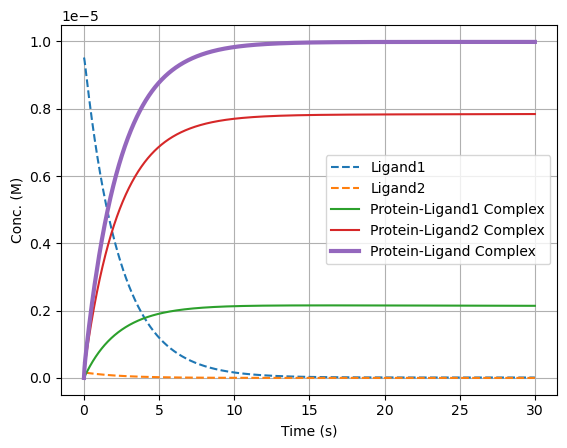

In [7]:
# Plot the concentrations over time
#plt.plot(t, P, label='Protein')
plt.plot(t, L1, linestyle='--', label='Ligand1')
plt.plot(t, L2, linestyle='--', label='Ligand2')
plt.plot(t, PL1, label='Protein-Ligand1 Complex')
plt.plot(t, PL2, label='Protein-Ligand2 Complex')
plt.plot(t, PL1+PL2, linewidth=3, label='Protein-Ligand Complex')

plt.xlabel('Time (s)')
plt.ylabel('Conc. (M)')
plt.grid()
plt.legend()
plt.show()

notice how the Protein-Ligand2 complex (red) ends up being higher than the Protein-Ligand1 complex (green), even though tautomer 1 is more abundant. This is because tautomer 1 is much less potent, so it's bound fraction is smaller. 

but what we really care about is the total complexed protein (purple), because that's what we would observe experimentally and so it is what would give us the apparent, aka observed, Ki. In lieu of actually doing this experiment, let's add the `PL1` and `PL2` concentrations from our simulation, and infer the on-rates and off-rates. Then we have observed K_eq as `observed on-rate / observed off-rate`.

Practically, this is achieved by fitting an ODE model with scipy.optimize to the purple curve. We change the ODE to assume there is a single ligand species, i.e. the we fit an ODE model that assumes `P+L<->PL`

In [8]:
# Define the rate equations
def rate_equations(y, t, k_on, k_off):
    P, L, PL = y  # Unpack the concentrations
    
    # Rate equations
    dPdt = -k_on * P * L + k_off * PL
    dLdt = -k_on * P * L + k_off * PL
    dPLdt = k_on * P * L - k_off * PL
    
    return [dPdt, dLdt, dPLdt]
    

and now, to fitting. Note that I tried scipy.optimize.minimize but the gradient was too flat in the precision range. I found that the 'DIRECT' algorithm available in scipy.optimize finds a solution quickly, is consistent over time, and doesn't take long to complete. I guess it is gradient-free.

In [9]:
#this is our target data, it's the observed "PL" in P+L<->PL
observed = np.array(PL1+PL2)

def fitting_function(pars):
    """
    This is a loss function for a given set of on-rate and off-rates
    The on-rate and off-rate are in logspace, allowing the model to fit 
    more smoothly. So the first step is to transform back to linear space. 
    """
    k_on, k_off = pars
    k_on = 10**k_on # transform to linear space
    k_off = 10**k_off # transform to linear space
    #P0 = ...#already been set.
    PL0 = 0
    L0 = L1_0+L2_0 #already been set. It's the sum of equilibrated L1 and L2 populations.
    
    y0 = [P0, L0, PL0]
    #generate a simulated curve.
    y = odeint(rate_equations, y0, t, args=(k_on, k_off))

    #see how closely this curve matches the observed data. 
    rmse = ((y[:,-1]-observed)**2).sum()
    return rmse


res = optimize.direct(fitting_function,maxfun= 5_000,
                      bounds=[(1,9),
                             (-6,1)]
                      )
res

 message: Number of function evaluations done is larger than maxfun=5000
 success: False
  status: 1
     fun: 2.17402943434234e-12
       x: [ 3.653e+00 -3.299e+00]
     nit: 271
    nfev: 5013

OK the loss is very small, so our observed, apparent, P+L<->PL system must be behaving pretty closely to the simulated ligand species kinetics model. 

So we can calculate the observed Ki, and this would be a reasonable simulation of our belief about the Ki in a real life experiment. 

First let's just plot the overlap of the equilibration process to make doubly sure:

In [10]:
res.x

array([ 3.6532315 , -3.29852326])

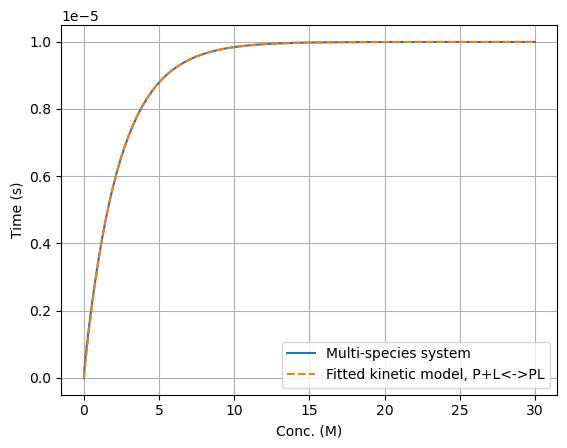

In [11]:
k_on, k_off = res.x
k_on = 10**k_on # transform to linear space
k_off = 10**k_off # transform to linear space 
#P0 = ...#already set.
PL0 = 0
L0 = L1_0+L2_0
y0 = [P0, L0, PL0]

y = odeint(rate_equations, y0, t, args=(k_on, k_off))

plt.plot(t, observed, label="Multi-species system")
plt.plot(t, y[:,-1], linestyle='--', label='Fitted kinetic model, P+L<->PL')
plt.xlabel('Conc. (M)')
plt.ylabel('Time (s)')
plt.legend()
plt.grid()

after all that, this is our apparent Ki:

In [12]:
observed_ki = 1/(k_on/k_off)
print(observed_ki)

1.1174941097085943e-07


# now compare our apparent Ki to the master equation Ki.

the master equation says we sum the equilibrium binding constants of the ligand species, weighted by their fraction in the unbound population.

i.e. `K_eq = f1*keq1 + f2*keq2 + ....`

In [13]:
#combined K_eq:
true_k_eq = f1 * true_taut1_k_eq + f2 * true_taut2_k_eq
true_ki = 1/true_k_eq
true_ki

9.546538413893563e-08

the master equation says our combined Ki should be something like 95 nM. Note that this is a pretty big drop from the true Ki of tautomer 2, which was 5 nM, but it's also substantially _better_ than our tautomer 1, whch was 5 µM!

In [14]:
print("Combined Ki using the master equation method, in µM:")
print(np.around(true_ki*1e6, 4))
print("Observed Ki by fitting an ODE model, in µM:")
print(np.around(observed_ki*1e6, 4))

Combined Ki using the master equation method, in µM:
0.0955
Observed Ki by fitting an ODE model, in µM:
0.1117


In [15]:
print('Fractional difference in master equation to our observed Ki:')
observed_ki/true_ki

Fractional difference in master equation to our observed Ki:


1.1705751983171704

pretty close!

finally, after I wrote this, I realised it's more complicated than it needs to be. K_eq is on-rate/off-rate, but it's also `[P][L]/[PL]` at equilibrium. So we didn't need to fit an ODE, but it was fun. Here's the easy way:

In [16]:

final_state = y[-1]
observed_ki = (final_state[0]*final_state[1]) / (final_state[2])

print("Combined Ki using the master equation method, in µM:")
print(np.around(true_ki*1e6, 4))
print("Observed Ki by fitting an ODE model, in µM:")
print(np.around(observed_ki*1e6, 4))

Combined Ki using the master equation method, in µM:
0.0955
Observed Ki by fitting an ODE model, in µM:
0.1076


it's actually a bit better

In [17]:
print('Fractional difference in master equation to our observed Ki:')
observed_ki/true_ki

Fractional difference in master equation to our observed Ki:


1.1268707523680856

# conclusion. 

so it looks like the master equation is pretty good. It's not clear whether the simulation is imperfect (likely) or whether the master equation is imperfect (it appears thermodynamically rigorous!) or if the assumptions I made about kinetic rates mean the applicability domain is a bit off.

And it looks like a 5% occupancy tautomer is fine if it's potent enough. 